# Importar librerias

In [3]:
%load_ext autoreload
%autoreload 2

import dgl
import torch
from torch.optim import Adam
import itertools
import torch.nn.functional as F


from modules.gnn import GNN
from modules.predictors import DotPredictor, MLPPredictor
from modules.models import  ModelGraphSAGE, GraphSAGE, GCN, ModelGCN, ModelSAGESample #ModelGraphSAGE,GraphSAGE, GCN,ModelSAGESample,SAGE, ModelGCN
from utils import plot_roc_curve, plot_training

import pandas as pd


/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

Versión de DGL: 2.4.0+cu121
Versión de PyTorch: 2.3.0+cu121


# Diccionario de casos de prueba

In [4]:
cases = {
    "CASO_1": {
        "data_path": "data/DGL_Graph/MultiDiGraph_AllFeatures/",
        "features_type": "AllFeatures",
        "size_train": 0.8,
        "model": GCN,
        "predictor": MLPPredictor,
        'description': 'GCN con predictor de MLP'
    },
    "CASO_4": {
        "data_path": "data/DGL_Graph/MultiDiGraph_AllFeatures/",
        "features_type": "AllFeatures",
        "size_train": 0.8,
        "model": GraphSAGE,
        "predictor": MLPPredictor,
        "description": "GraphSAGE con predictor de MLP"
    }
}

# Funciones Auxiliares

In [6]:

def load_and_prepare_data(data_path, size_train):
    gnn = GNN(debug=True)
    gnn.load_dataset(data_path, force_reload=True)
    gnn.split_dataset(size_train)
    # gnn.split_dtaset_v2()
    gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
    return gnn


def initialize_model(gnn, model, predictor, lr ,h_feats_model, out_feat_model , out_feat_predictor = None):
    in_feats = gnn.dgl_graph.ndata['feat'].shape[1]

    model = model(in_feats, h_feats_model, out_feat_model)
    pred = predictor( out_feat_model, out_feat_predictor)
    
    optimizer = Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)
    return model, pred, optimizer

def train_model(case, gnn, model, pred, optimizer, epochs=100):
    train_mask = gnn.train_mask
    val_mask = gnn.val_mask
    labels = gnn.dgl_graph.edata["Relationship"].long()

    model_complexity = []
    acc_val = []
    acc_train = []
    train_error = []
    val_error = []

    for epoch in range(epochs):
        # forward
        h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
        logits = pred(gnn.dgl_graph, h)
        scores = logits.argmax(1)

        # Calculo pérdida
        train_loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        val_loss = F.cross_entropy(logits[val_mask], labels[val_mask])

        # Calculo accuracy
        train_acc = (scores[train_mask] == labels[train_mask]).float().mean().item()
        val_acc = (scores[val_mask] == labels[val_mask]).float().mean().item()

        # Guardar valores
        train_error.append(train_loss.item())
        val_error.append(val_loss.item())
        acc_train.append(train_acc)
        acc_val.append(val_acc)
        model_complexity.append(epoch + 1)

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print('In epoch {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # Guardar los valores en un archivo CSV
    df = pd.DataFrame({
        'epoch': model_complexity,
        'train_error': train_error,
        'val_error': val_error,
        'acc_train': acc_train,
        'acc_val': acc_val
    })
    df.to_csv(f'results/multiclass_classification/training_results_{case}.csv', index=False)

    return logits, train_error, val_error, acc_train, acc_val, model_complexity


def evaluate_model(gnn, logits, test_mask):
    true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
    predicted_train_scores = logits.detach().numpy()[test_mask]
    optimal_threshold = plot_roc_curve(true_train_labels, predicted_train_scores)
    return optimal_threshold


# Entrenamiento 

[CASO_1]
Done saving data into cached files.
Graph(num_nodes=74145, num_edges=923778,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 738417
Validation edges: 92687
Test edges: 92674
In epoch 0, train loss: 1.1245814561843872, val loss: 1.1244268417358398
In epoch 20, train loss: 0.4933571219444275, val loss: 0.4906140863895416
In epoch 40, train loss: 0.38498634099960327, val loss: 0.3826236128807068
In epoch 60, train loss: 0.2828977108001709, val loss: 0.27971968054771423
In epoch 80, train loss: 0.24894677102565765, val loss: 0.2460915744304657


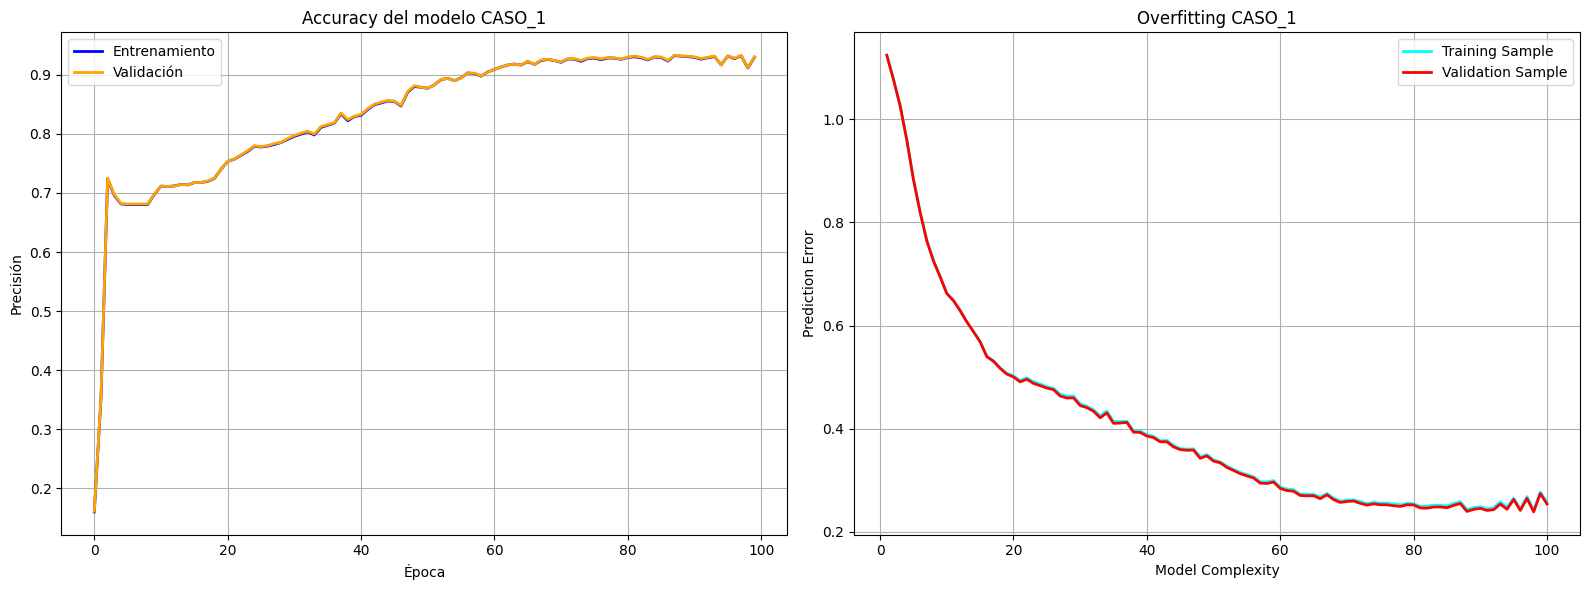

------------------------------------------------------
------------------------------------------------------
[CASO_4]
Done saving data into cached files.
Graph(num_nodes=74145, num_edges=923778,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 738583
Validation edges: 92546
Test edges: 92649
In epoch 0, train loss: 1.1018844842910767, val loss: 1.1022956371307373
In epoch 20, train loss: 0.6108304262161255, val loss: 0.609416127204895
In epoch 40, train loss: 0.40880087018013, val loss: 0.4081827402114868
In epoch 60, train loss: 0.2970644235610962, val loss: 0.2972553074359894
In epoch 80, train loss: 0.2608460485935211, val loss: 0.26276707649230957


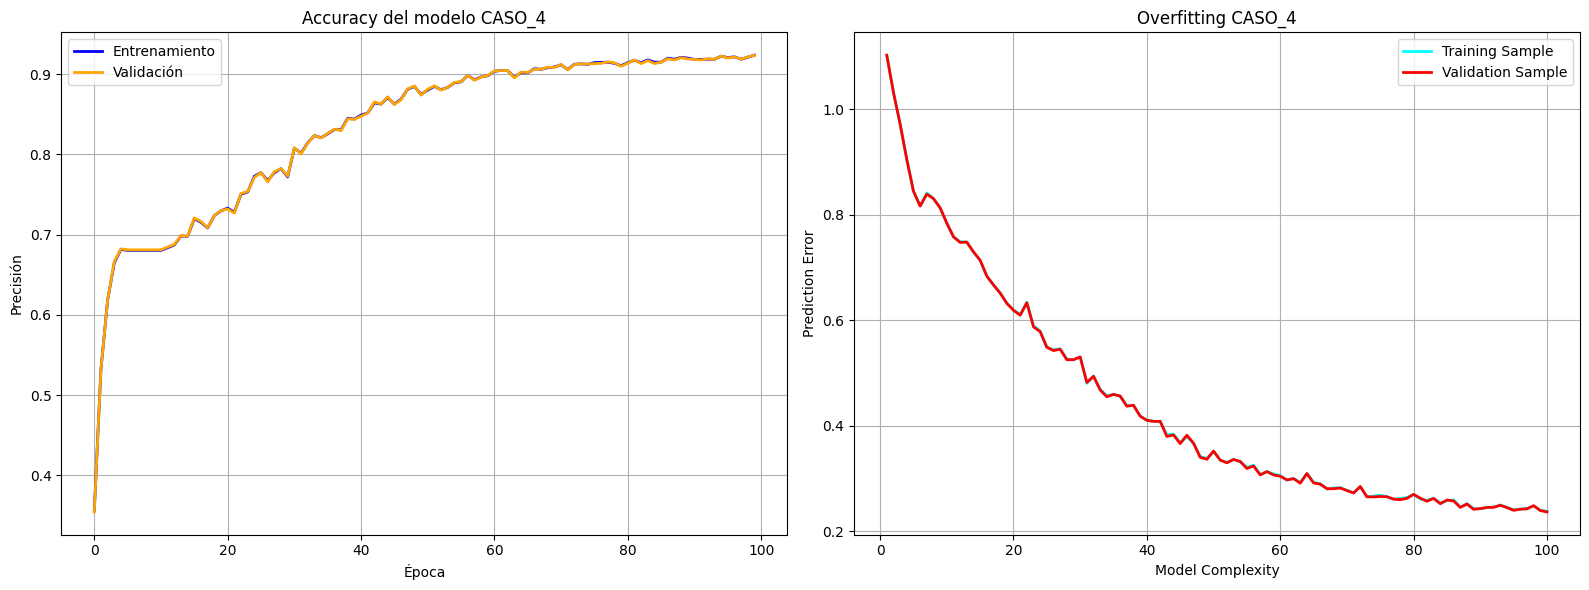

------------------------------------------------------
------------------------------------------------------


In [7]:
for case_name, case in cases.items():
    print(f"[{case_name}]")

    data_path = case["data_path"]
    size_train = case["size_train"]

    # ----------- 1. Cargar grafo y preparar datos -------------- #
    gnn = load_and_prepare_data(data_path, size_train)
    

    # ----------- 2. Inicializa modelo -------------------------- #
    model = case["model"]
    predictor = case["predictor"]
    lr = 0.01
    h_feats_model = 16
    out_feat_model = 8
    out_feat_predictor = 3 # num clases
    model, pred, optimizer = initialize_model(gnn, model, predictor, lr ,h_feats_model, out_feat_model , out_feat_predictor)


    # ----------- 3. Entrenar modelo ----------------------------- #
    logits, train_error, val_error, acc_train, acc_val, model_complexity = train_model(case_name, gnn, model, pred, optimizer, epochs=100)

    # ----------- 4. Plotear resultados ----------------------------- #
    plot_training(case_name,gnn,train_error,acc_train,val_error,acc_val,model_complexity)

    print("------------------------------------------------------")
    print("------------------------------------------------------")